In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import math

from pandas import read_csv
from scipy.optimize import curve_fit
import pickle

import czifile
import cv2

from scipy import stats

import seaborn as sns
import copy


# 2D scan

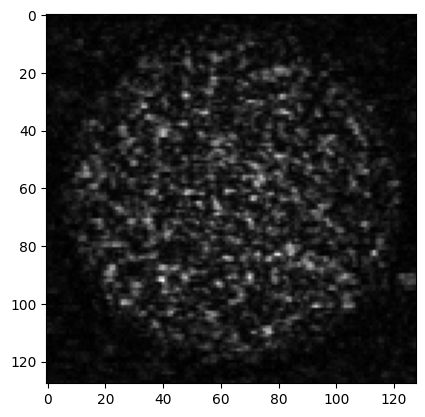

In [3]:
foldername='/Volumes/wwyyrx/Wenyun/Silk_speckle/20230524/'

h, w = 128,128

imgname='fresh_6'

# Read the CZI file
data = czifile.imread(foldername+imgname+'.czi')
framespeed=0.03

plt.imshow(data[0, 1, 0, 0, :, :, 0], cmap='gray')
plt.show()

## calculate spatial correlation

In [4]:
def spatial_correlation(example_img, sp_shape,ROI):
    y_length=example_img.shape[0]
    x_length=example_img.shape[1]
    num_pixels=y_length*x_length
    spcorrelation_map = np.zeros((sp_shape,sp_shape))
    for dy in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
        for dx in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
            sum_numerator=0
            sum_denum_1=0
            sum_denum_2=0
            count=0
            for y in range(ROI[0],ROI[0]+ROI[2],1):
                for x in range(ROI[1],ROI[1]+ROI[3],1):
                    sum_numerator+=int(example_img[y][x])*int(example_img[y+dy][x+dx])
                    sum_denum_1+=int(example_img[y][x])
                    sum_denum_2+=int(example_img[y+dy][x+dx])
                    count+=1
            numerator=sum_numerator/count
            denum_1=sum_denum_1/count
            denum_2=sum_denum_2/count
            spcorrelation_map[dy+math.floor(sp_shape/2)][dx+math.floor(sp_shape/2)]=copy.deepcopy(numerator/(denum_1*denum_2)-1)
    normalization=spcorrelation_map[math.floor(sp_shape/2)][math.floor(sp_shape/2)]
    spcorrelation_map=spcorrelation_map/normalization
    sns.heatmap(spcorrelation_map)
    return spcorrelation_map

In [5]:
def plot_spmap(spcorrelation_map):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.')
    plt.legend(['Correlation vs delta r'], fontsize=18)
    plt.xlabel("delta r [pixels]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.show

In [86]:
def calculate_speckle_size_x(spcorrelation_map,endidx,startidx=0,plotBoolean=True):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    
    spcorrelation_map_x=spcorrelation_map[int(spcorrelation_map.shape[0]/2)][:]
    # radius_squared=radius_flatten*radius_flatten
    #log_correlation=np.log(abs(spcorrelation_map_flatten))
    combined_list=[]
    combined_list.append(x_radius)
    combined_list.append(spcorrelation_map_x)
    combined_list=np.array(combined_list)
    print(combined_list.shape)
    sorted_indices = np.argsort(combined_list[0, :])
    combined_list_sorted = combined_list[:, sorted_indices]
    if plotBoolean==True:
        x, y = combined_list_sorted[0][startidx:endidx], combined_list_sorted[1][startidx:endidx]
        # curve fit
        sigma, _ = curve_fit(gaussian, x, y)
        print("speckle size is:",2.35*sigma)
        # plot input vs output
        plt.plot(x, y,'k.')
        
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 0.01)
        # calculate the output for the range
        y_line = gaussian(x_line, sigma)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.xlim(0,x[-1])
        plt.xlabel("Delta r [pixel]",fontsize=18)
        plt.ylabel("Correlation",fontsize=18)
        plt.show()
        return 2.35*sigma
    else:
        x, y = combined_list_sorted[0][0:20], combined_list_sorted[1][0:20]
        # curve fit
        sigma, _ = curve_fit(gaussian, x, y)
        return 2.35*sigma

def gaussian(x, stddev):
    return np.exp(-((x) ** 2) / (2 * stddev ** 2))

In [88]:
test=np.zeros((1,5))
test[0][0:100]

array([0., 0., 0., 0., 0.])

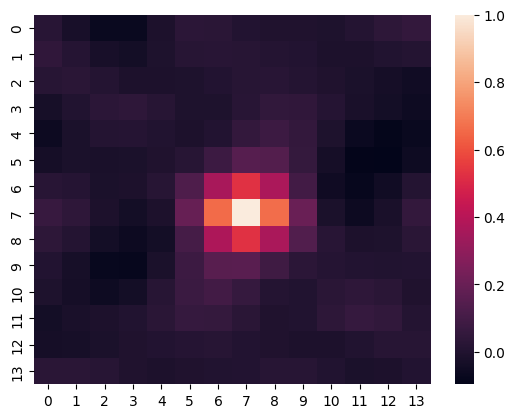

In [101]:
img_cal=data[0, 10, 0, 0, :, :, 0]
ROI=[40,40,50,50] #y,x,w,h
sp_shape=14
spmap=spatial_correlation(img_cal,sp_shape,ROI)

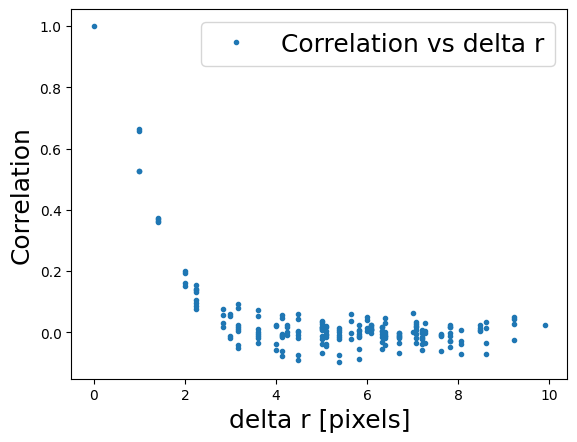

In [102]:
plot_spmap(spmap)

In [103]:
def plot_spmap_micron(spcorrelation_map):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)*0.157
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.')
    plt.legend(['Correlation vs delta r'], fontsize=18)
    plt.xlabel("delta r [um]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.show

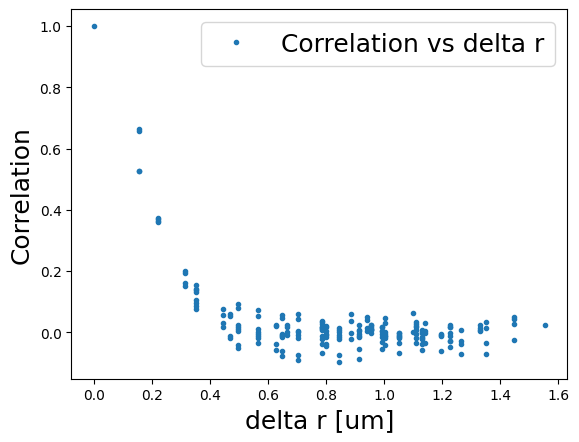

In [104]:
plot_spmap_micron(spmap)

# plot in um

(2, 14)
speckle size is: [2.56776359]


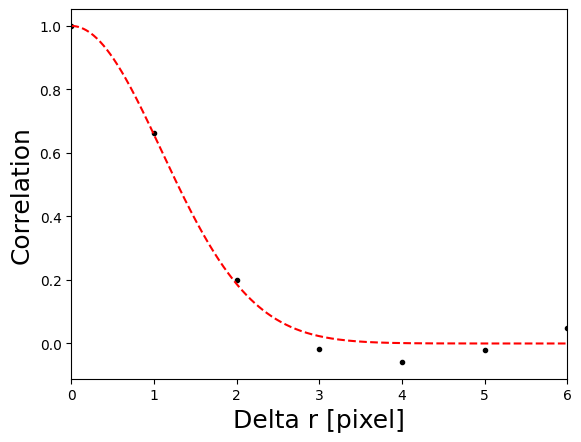

In [105]:
size=calculate_speckle_size_x(spmap,14)

In [106]:
size*0.157

array([0.40313888])

In [107]:
0.46*639/1.3

226.1076923076923

# 